In [9]:
import optuna
import numpy as np
import pandas as pd

In [75]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
submission = pd.read_csv('sample_submission.csv')

In [12]:
all_df = pd.concat([train_df, test_df], sort=False).reset_index(drop=True)

In [13]:
from sklearn.preprocessing import LabelEncoder
categories = all_df.columns[all_df.dtypes == "object"]
print(categories)

for cat in categories:
    le = LabelEncoder()
    print(cat)
    
    all_df[cat].fillna("missing", inplace=True)    
    le = le.fit(all_df[cat])
    all_df[cat] = le.transform(all_df[cat])
    all_df[cat] = all_df[cat].astype("category")

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')
MSZoning
Street
Alley
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Heating
HeatingQC
CentralAir
Electrical
KitchenQual
Functional
Fi

In [14]:
train_df_le = all_df[~all_df["SalePrice"].isnull()]
test_df_le = all_df[all_df["SalePrice"].isnull()]

In [15]:
import lightgbm as lgb

from sklearn.model_selection import KFold
folds = 3
kf = KFold(n_splits=folds)

In [16]:
lgbm_params = {
    "objective":"regression",
    "random_seed":1234
}

train_X = train_df_le.drop(["SalePrice", "Id"], axis=1) #설명변수
train_Y = train_df_le["SalePrice"] #목적변수

In [17]:
from sklearn.metrics import mean_squared_error

In [18]:
models = [] #fold 별로 작성한 모델 저장
rmses = [] #rmse의 계산 결과를 저장
oof = np.zeros(len(train_X)) #초기값 0, fold마다 인덱스 값 생성

for train_index, val_index in kf.split(train_X): #train_X를 분할한 결과의 인덱스 얻기
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
    print(X_train)
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)    
    
    model_lgb = lgb.train(lgbm_params,  #lightGBM 파라미터
                          lgb_train, 
                          valid_sets=lgb_eval, 
                          num_boost_round=100,
                          early_stopping_rounds=20,
                          verbose_eval=10,
                         )    
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration) #교차검증
    tmp_rmse = np.sqrt(mean_squared_error(np.log(y_valid), np.log(y_pred)))
    print(tmp_rmse)    
              
    models.append(model_lgb)    
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred 
    

      MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
487           20        3         70.0    12243      1     2        0   
488          190        3         60.0    10800      1     2        3   
489          180        4         21.0     1526      1     2        3   
490          160        4          NaN     2665      1     2        3   
491           50        3         79.0     9490      1     2        3   
...          ...      ...          ...      ...    ...   ...      ...   
1455          60        3         62.0     7917      1     2        3   
1456          20        3         85.0    13175      1     2        3   
1457          70        3         66.0     9042      1     2        3   
1458          20        3         68.0     9717      1     2        3   
1459          20        3         75.0     9937      1     2        3   

     LandContour Utilities LotConfig  ... ScreenPorch PoolArea PoolQC Fence  \
487            3         0         4  ...   

Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 1.78839e+09
[20]	valid_0's l2: 1.03494e+09
[30]	valid_0's l2: 8.76655e+08
[40]	valid_0's l2: 8.61221e+08
[50]	valid_0's l2: 8.70283e+08
[60]	valid_0's l2: 8.52573e+08
[70]	valid_0's l2: 8.36406e+08
[80]	valid_0's l2: 8.38037e+08
[90]	valid_0's l2: 8.45503e+08
[100]	valid_0's l2: 8.45187e+08
Did not meet early stopping. Best iteration is:
[81]	valid_0's l2: 8.35675e+08
0.1327709996964391


<Axes: >

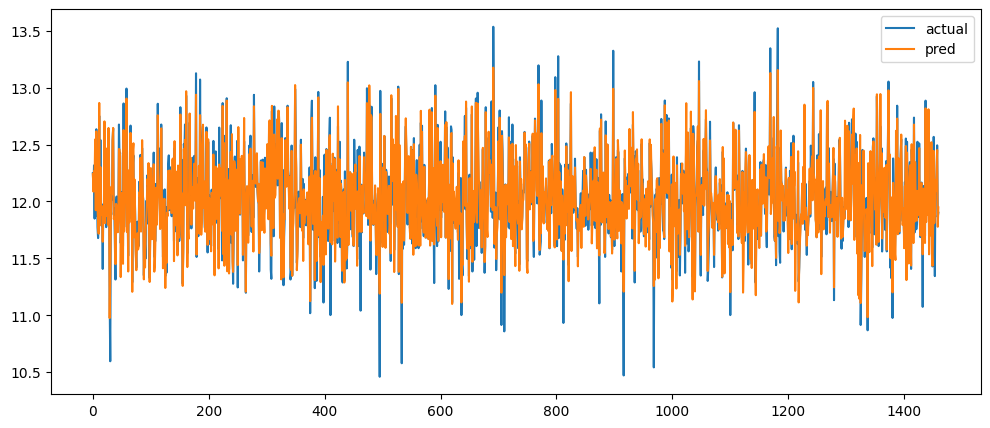

In [24]:
actual_pred_df = pd.DataFrame({
    "actual" : train_Y, #실제값
    "pred" : oof }) #예측값
    
actual_pred_df.plot(figsize=(12,5))

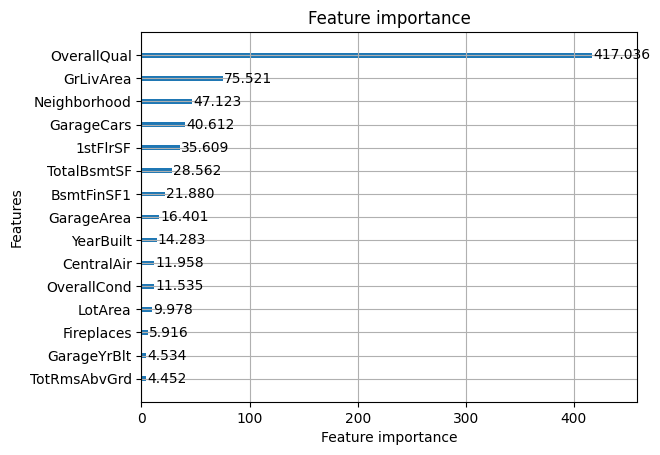

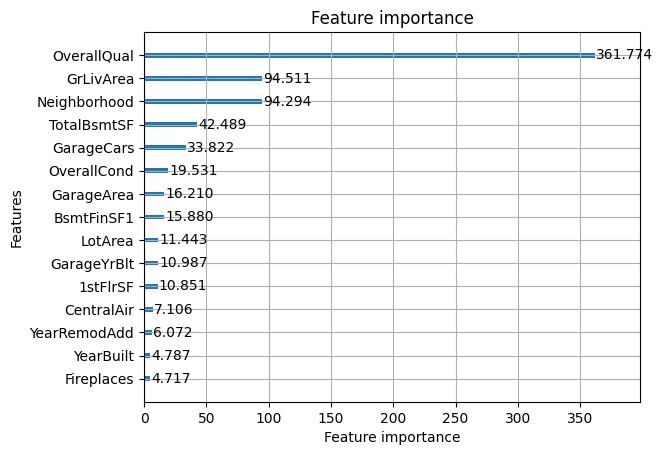

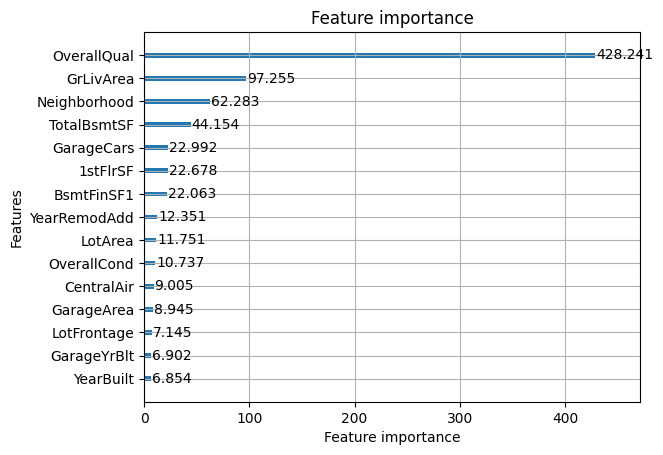

In [25]:
for model in models:
    lgb.plot_importance(model,importance_type="gain", max_num_features=15)

<Axes: ylabel='Frequency'>

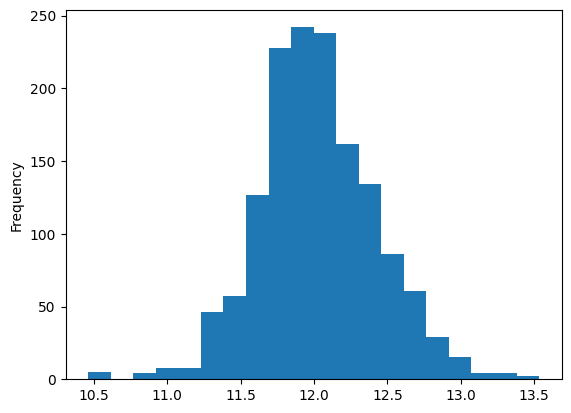

In [26]:
np.log(train_df['SalePrice'])
np.log(train_df['SalePrice']).plot.hist(bins=20)

In [27]:
pd.options.mode.chained_assignment = None #경고문 비활성화
train_df_le["SalePrice_log"] = np.log(train_df_le["SalePrice"]) #로그 값 열 생성

train_X = train_df_le.drop(["SalePrice","SalePrice_log","Id"], axis=1) #목적변수, 로그변수, ID 제외한 train_X로 생성
train_Y = train_df_le["SalePrice_log"] #로그화된 목적 변수를 train_Y에 할당

In [19]:
pd.options.mode.chained_assignment = None #경고문 비활성화
train_df_le["SalePrice_log"] = np.log(train_df_le["SalePrice"]) #로그 값 열 생성

train_X = train_df_le.drop(["SalePrice","SalePrice_log","Id"], axis=1) #목적변수, 로그변수, ID 제외한 train_X로 생성
train_Y = train_df_le["SalePrice_log"] #로그화된 목적 변수를 train_Y에 할당

In [20]:
import warnings
warnings.filterwarnings("ignore")

models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
        
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)    
    
    model_lgb = lgb.train(lgbm_params, 
                          lgb_train, 
                          valid_sets=lgb_eval, 
                          num_boost_round=100,
                          early_stopping_rounds=20,
                          verbose_eval=10,
                         )    
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)    
              
    models.append(model_lgb)    
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred

Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0435757
[20]	valid_0's l2: 0.0222742
[30]	valid_0's l2: 0.0178641
[40]	valid_0's l2: 0.0167218
[50]	valid_0's l2: 0.0164435
[60]	valid_0's l2: 0.0162049
[70]	valid_0's l2: 0.0160662
[80]	valid_0's l2: 0.0159922
[90]	valid_0's l2: 0.0160502
Early stopping, best iteration is:
[75]	valid_0's l2: 0.0159661
0.12635697731896975
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.048724
[20]	valid_0's l2: 0.0277188
[30]	valid_0's l2: 0.0226077
[40]	valid_0's l2: 0.0211534
[50]	valid_0's l2: 0.0206503
[60]	valid_0's l2: 0.0204751
[70]	valid_0's l2: 0.0203809
[80]	valid_0's l2: 0.0203424
[90]	valid_0's l2: 0.0202764
[100]	valid_0's l2: 0.020244
Did not meet early stopping. Best iteration is:
[94]	valid_0's l2: 0.0202107
0.14216440722442905
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0387887
[20]	valid_0's l2: 0.0208522
[30]	valid_0's l2: 0.0175332

In [28]:
all_df = pd.concat([train_df, test_df], sort=False).reset_index(drop=True)
categories = all_df.columns[all_df.dtypes == "object"]
print(categories)

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')


In [29]:
all_df.isnull().sum().sort_values(ascending=False).head(40)

PoolQC           2909
MiscFeature      2814
Alley            2721
Fence            2348
MasVnrType       1766
SalePrice        1459
FireplaceQu      1420
LotFrontage       486
GarageYrBlt       159
GarageFinish      159
GarageQual        159
GarageCond        159
GarageType        157
BsmtExposure       82
BsmtCond           82
BsmtQual           81
BsmtFinType2       80
BsmtFinType1       79
MasVnrArea         23
MSZoning            4
Functional          2
BsmtFullBath        2
Utilities           2
BsmtHalfBath        2
Electrical          1
TotalBsmtSF         1
BsmtUnfSF           1
KitchenQual         1
BsmtFinSF2          1
BsmtFinSF1          1
SaleType            1
GarageCars          1
Exterior2nd         1
Exterior1st         1
GarageArea          1
YrSold              0
Fireplaces          0
MoSold              0
MiscVal             0
SaleCondition       0
dtype: int64

In [30]:
all_df.loc[~all_df["PoolQC"].isnull(), "PoolQC"] = 1
all_df.loc[all_df["PoolQC"].isnull(), "PoolQC"] = 0

#miscfeature
all_df.loc[~all_df["MiscFeature"].isnull(), "MiscFeature"] = 1
all_df.loc[all_df["MiscFeature"].isnull(), "MiscFeature"] = 0

#alley
all_df.loc[~all_df["Alley"].isnull(), "Alley"] = 1
all_df.loc[all_df["Alley"].isnull(), "Alley"] = 0

#for문으로 표현
HighFacility_col = ["PoolQC","MiscFeature","Alley"]
for col in HighFacility_col:
    if all_df[col].dtype == "object":
        if len(all_df[all_df[col].isnull()]) > 0:
            all_df.loc[~all_df[col].isnull(), col] = 1
            all_df.loc[all_df[col].isnull(), col] = 0

In [23]:
all_df["hasHighFacility"] = all_df["PoolQC"] + all_df["MiscFeature"] + all_df["Alley"]
all_df["hasHighFacility"] = all_df["hasHighFacility"].astype(int) #int형으로 변환

all_df["hasHighFacility"].value_counts()

all_df = all_df.drop(["PoolQC","MiscFeature","Alley"],axis=1) #고급 설비 관련 컬럼 삭제

TypeError: unsupported operand type(s) for +: 'Categorical' and 'Categorical'

In [31]:
all_df["hasHighFacility"] = all_df["PoolQC"] + all_df["MiscFeature"] + all_df["Alley"]
all_df["hasHighFacility"] = all_df["hasHighFacility"].astype(int) #int형으로 변환

all_df["hasHighFacility"].value_counts()

all_df = all_df.drop(["PoolQC","MiscFeature","Alley"],axis=1)

In [32]:
train_df_num = train_df.select_dtypes(include=[np.number])
#비례 척도가 아닌 변수
nonratio_features = ["Id", "MSSubClass", "OverallQual", "OverallCond", "YearBuilt", "YearRemodAdd", "MoSold", "YrSold"]
num_features = sorted(list(set(train_df_num) - set(nonratio_features)))
num_features

train_df_num_rs = train_df_num[num_features] #비례 척도만 추출|

In [33]:
#75%가 0이 변수
for col in num_features:
    if train_df_num_rs.describe()[col]["75%"] == 0:
        print(col, len(train_df_num_rs[train_df_num_rs[col] == 0]))
        
#특정값만 갖는 경우
for col in num_features:
    if train_df_num_rs[col].nunique() < 15:
        print(col, train_df_num_rs[col].nunique())
        
#이상치 변수
for col in num_features:
    tmp_df = train_df_num_rs[(train_df_num_rs[col] > train_df_num_rs[col].mean() + train_df_num_rs[col].std()*3) | \
    (train_df_num_rs[col] < train_df_num_rs[col].mean() - train_df_num_rs[col].std()*3)]
    print(col, len(tmp_df))

3SsnPorch 1436
BsmtFinSF2 1293
BsmtHalfBath 1378
EnclosedPorch 1252
LowQualFinSF 1434
MiscVal 1408
PoolArea 1453
ScreenPorch 1344
BedroomAbvGr 8
BsmtFullBath 4
BsmtHalfBath 3
Fireplaces 4
FullBath 4
GarageCars 5
HalfBath 3
KitchenAbvGr 4
PoolArea 8
TotRmsAbvGrd 12
1stFlrSF 12
2ndFlrSF 4
3SsnPorch 23
BedroomAbvGr 14
BsmtFinSF1 6
BsmtFinSF2 50
BsmtFullBath 16
BsmtHalfBath 82
BsmtUnfSF 11
EnclosedPorch 51
Fireplaces 5
FullBath 0
GarageArea 7
GarageCars 0
GarageYrBlt 1
GrLivArea 16
HalfBath 12
KitchenAbvGr 68
LotArea 13
LotFrontage 12
LowQualFinSF 20
MasVnrArea 32
MiscVal 8
OpenPorchSF 27
PoolArea 7
SalePrice 22
ScreenPorch 55
TotRmsAbvGrd 12
TotalBsmtSF 10
WoodDeckSF 22


In [35]:
categories = categories.drop(["PoolQC","MiscFeature","Alley"])


for cat in categories:
    le = LabelEncoder()
    print(cat)
    
    all_df[cat].fillna("missing", inplace=True) #결측치를 Missing으로 대체    
    le = le.fit(all_df[cat])
    all_df[cat] = le.transform(all_df[cat])
    all_df[cat] = all_df[cat].astype("category")
    

train_df_le = all_df[~all_df["SalePrice"].isnull()] 
test_df_le = all_df[all_df["SalePrice"].isnull()] 

train_df_le["SalePrice_log"] = np.log(train_df_le["SalePrice"])
train_X = train_df_le.drop(["SalePrice","SalePrice_log", "Id"], axis=1)
train_Y = train_df_le["SalePrice_log"]

models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
        
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)    
    
    model_lgb = lgb.train(lgbm_params, 
                          lgb_train, 
                          valid_sets=lgb_eval, 
                          num_boost_round=100,
                          early_stopping_rounds=20,
                          verbose_eval=10,
                         )    
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)    
              
    models.append(model_lgb)    
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred 

MSZoning
Street
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Heating
HeatingQC
CentralAir
Electrical
KitchenQual
Functional
FireplaceQu
GarageType
GarageFinish
GarageQual
GarageCond
PavedDrive
Fence
SaleType
SaleCondition
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0424478
[20]	valid_0's l2: 0.0221391
[30]	valid_0's l2: 0.0176454
[40]	valid_0's l2: 0.0163936
[50]	valid_0's l2: 0.0162319
[60]	valid_0's l2: 0.0161439
[70]	valid_0's l2: 0.0161796
[80]	valid_0's l2: 0.0161966
[90]	valid_0's l2: 0.0161571
[100]	valid_0's l2: 0.0161633
Did not meet early stopping. Best iteration is:
[88]	valid_0's l2: 0.0161105
0.12691187506430074
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0474357
[20]	valid_0's l2: 0.0270911
[30]	va

In [34]:
all_df = all_df[(all_df['BsmtFinSF1'] < 2000) | (all_df['SalePrice'].isnull())]
all_df = all_df[(all_df['TotalBsmtSF'] < 3000) | (all_df['SalePrice'].isnull())]
all_df = all_df[(all_df['GrLivArea'] < 4500) | (all_df['SalePrice'].isnull())]
all_df = all_df[(all_df['1stFlrSF'] < 2500) | (all_df['SalePrice'].isnull())]
all_df = all_df[(all_df['LotArea'] < 100000) | (all_df['SalePrice'].isnull())]

In [36]:
all_df["Age"] = all_df["YrSold"] - all_df["YearBuilt"]

train_df_le = all_df[~all_df["SalePrice"].isnull()] 
test_df_le = all_df[all_df["SalePrice"].isnull()] 

train_df_le["SalePrice_log"] = np.log(train_df_le["SalePrice"])
train_X = train_df_le.drop(["SalePrice","SalePrice_log","Id"], axis=1)
train_Y = train_df_le["SalePrice_log"]

models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
        
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)    
    
    model_lgb = lgb.train(lgbm_params, 
                          lgb_train, 
                          valid_sets=lgb_eval, 
                          num_boost_round=100,
                          early_stopping_rounds=20,
                          verbose_eval=10,
                         )    
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)    
              
    models.append(model_lgb)    
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred 

Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0427712
[20]	valid_0's l2: 0.0222468
[30]	valid_0's l2: 0.0178227
[40]	valid_0's l2: 0.0166019
[50]	valid_0's l2: 0.0163129
[60]	valid_0's l2: 0.0163467
[70]	valid_0's l2: 0.0163411
Early stopping, best iteration is:
[55]	valid_0's l2: 0.0162479
0.1274567006026756
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0472863
[20]	valid_0's l2: 0.0272598
[30]	valid_0's l2: 0.022684
[40]	valid_0's l2: 0.0208361
[50]	valid_0's l2: 0.0204121
[60]	valid_0's l2: 0.0202398
[70]	valid_0's l2: 0.0200796
[80]	valid_0's l2: 0.0200148
[90]	valid_0's l2: 0.0199188
[100]	valid_0's l2: 0.0197431
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.0197431
0.14051005639296832
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0369088
[20]	valid_0's l2: 0.0196054
[30]	valid_0's l2: 0.0163427
[40]	valid_0's l2: 0.0155428
[50]	valid_0's l2: 0.015222

In [37]:
all_df[["LotArea","MasVnrArea","BsmtUnfSF","TotalBsmtSF", "1stFlrSF", "2ndFlrSF", "LowQualFinSF", "GrLivArea", "GarageArea","WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch", "PoolArea", "LotFrontage"]].describe()

all_df["TotalSF"] = all_df["TotalBsmtSF"] + all_df["1stFlrSF"] + all_df["2ndFlrSF"]
all_df["Total_Bathrooms"] = all_df["FullBath"] + all_df["HalfBath"] + all_df["BsmtFullBath"] + all_df["BsmtHalfBath"]

#porch 넓이의 합,
all_df["Total_PorchSF"] = all_df["WoodDeckSF"] + all_df["OpenPorchSF"] + all_df["EnclosedPorch"] + all_df["3SsnPorch"] + all_df["ScreenPorch"]
all_df["hasPorch"] = all_df["Total_PorchSF"].apply(lambda x: 1 if x > 0 else 0)
all_df = all_df.drop("Total_PorchSF",axis=1)

train_df_le = all_df[~all_df["SalePrice"].isnull()] 
test_df_le = all_df[all_df["SalePrice"].isnull()] 

train_df_le["SalePrice_log"] = np.log(train_df_le["SalePrice"])
train_X = train_df_le.drop(["SalePrice","SalePrice_log","Id"], axis=1)
train_Y = train_df_le["SalePrice_log"]

models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
        
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)    
    
    model_lgb = lgb.train(lgbm_params, 
                          lgb_train, 
                          valid_sets=lgb_eval, 
                          num_boost_round=100,
                          early_stopping_rounds=20,
                          verbose_eval=10,
                         )    
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)    
              
    models.append(model_lgb)    
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred 

Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0388123
[20]	valid_0's l2: 0.019933
[30]	valid_0's l2: 0.0165909
[40]	valid_0's l2: 0.015977
[50]	valid_0's l2: 0.0158245
[60]	valid_0's l2: 0.0157696
[70]	valid_0's l2: 0.0157857
[80]	valid_0's l2: 0.0158773
Early stopping, best iteration is:
[62]	valid_0's l2: 0.0157218
0.12538652955165416
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0459257
[20]	valid_0's l2: 0.0263207
[30]	valid_0's l2: 0.0217538
[40]	valid_0's l2: 0.0202895
[50]	valid_0's l2: 0.0198426
[60]	valid_0's l2: 0.0196631
[70]	valid_0's l2: 0.0196107
[80]	valid_0's l2: 0.0195612
Early stopping, best iteration is:
[65]	valid_0's l2: 0.0195496
0.13981974818092313
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0354828
[20]	valid_0's l2: 0.0183241
[30]	valid_0's l2: 0.0154896
[40]	valid_0's l2: 0.0144641
[50]	valid_0's l2: 0.0141813
[60]	valid_0's l2: 0.0141533
[70]	valid_0'

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_Y, test_size = 0.2, random_state = 1234, shuffle = False, stratify = None)


In [55]:
def objective(trial):
    params = {
        "objective": "regression", #함수를 회귀로 설정
        "random_seed": 1234,
        "learning_rate": 0.05, #학습률을 0.05로 설정
        "n_estimators": 1000, #트리의 개수
        "num_leaves": trial.suggest_int("num_leaves", 4, 64), #탐색할 범위를 4~64
        "max_bin": trial.suggest_int("max_bin", 50, 200), #탐색할 범위를 50~200
        "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 0.9), # 탐색할 범위를 0.4에서 0.9 사이
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10), #탐색할 범위를 1에서 10 사이
        "feature_fraction": trial.suggest_uniform("feature_fraction", 0.4, 0.9), #탐색할 범위를 0.4에서 0.9 사이
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 16), #탐색할 범위를 2에서 16 사이
        "min_sum_hessian_in_leaf": trial.suggest_int("min_sum_hessian_in_leaf", 1, 10), #탐색할 범위를 1에서 10 사이
    }
    
    lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False) #free_raw_data = False를 적어야 오류가 안남
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train, free_raw_data=False)
    
    model_lgb = lgb.train(
        params,
        lgb_train,
        valid_sets=lgb_eval,
        num_boost_round=100,
        early_stopping_rounds=20,
        verbose_eval=10,
    )
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    score = np.sqrt(mean_squared_error(y_valid, y_pred))
    return score

In [56]:
study = optuna.create_study(sampler = optuna.samplers.RandomSampler(seed=0))
study.optimize(objective, n_trials = 50) #50회의 시행 중 가장 정확한 파라미터
study.best_params

Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0644453
[20]	valid_0's l2: 0.0346719
[30]	valid_0's l2: 0.0229916
[40]	valid_0's l2: 0.0182991
[50]	valid_0's l2: 0.0161761
[60]	valid_0's l2: 0.0155148
[70]	valid_0's l2: 0.0152372
[80]	valid_0's l2: 0.0150177
[90]	valid_0's l2: 0.0146812
[100]	valid_0's l2: 0.0146973
[110]	valid_0's l2: 0.0146761
[120]	valid_0's l2: 0.0146636
[130]	valid_0's l2: 0.0146335


[I 2024-04-06 01:15:03,267] Trial 0 finished with value: 0.12096909717257005 and parameters: {'num_leaves': 48, 'max_bin': 97, 'bagging_fraction': 0.7575946831862097, 'bagging_freq': 4, 'feature_fraction': 0.8289728088113784, 'min_data_in_leaf': 9, 'min_sum_hessian_in_leaf': 10}. Best is trial 0 with value: 0.12096909717257005.


[140]	valid_0's l2: 0.0146833
[150]	valid_0's l2: 0.0147113
Early stopping, best iteration is:
[130]	valid_0's l2: 0.0146335
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0661297
[20]	valid_0's l2: 0.0364927
[30]	valid_0's l2: 0.024492
[40]	valid_0's l2: 0.0194895
[50]	valid_0's l2: 0.0170738
[60]	valid_0's l2: 0.0158525
[70]	valid_0's l2: 0.0154143
[80]	valid_0's l2: 0.0154866
[90]	valid_0's l2: 0.0151324
[100]	valid_0's l2: 0.0150305
[110]	valid_0's l2: 0.0148058
[120]	valid_0's l2: 0.0145409


[I 2024-04-06 01:15:03,663] Trial 1 finished with value: 0.11993159255388675 and parameters: {'num_leaves': 23, 'max_bin': 71, 'bagging_fraction': 0.5921908536463499, 'bagging_freq': 8, 'feature_fraction': 0.8458865003910399, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 2}. Best is trial 1 with value: 0.11993159255388675.


[130]	valid_0's l2: 0.0144153
[140]	valid_0's l2: 0.0144853
[150]	valid_0's l2: 0.0144417
Early stopping, best iteration is:
[131]	valid_0's l2: 0.0143836
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0664485
[20]	valid_0's l2: 0.0367956
[30]	valid_0's l2: 0.0248174
[40]	valid_0's l2: 0.0194238
[50]	valid_0's l2: 0.0171174
[60]	valid_0's l2: 0.0160468
[70]	valid_0's l2: 0.0153824
[80]	valid_0's l2: 0.0152349
[90]	valid_0's l2: 0.0150467
[100]	valid_0's l2: 0.0147548
[110]	valid_0's l2: 0.0146217
[120]	valid_0's l2: 0.0145543
[130]	valid_0's l2: 0.0146293
[140]	valid_0's l2: 0.0145184
[150]	valid_0's l2: 0.0144571
[160]	valid_0's l2: 0.0144991
Early stopping, best iteration is:
[149]	valid_0's l2: 0.0144405


[I 2024-04-06 01:15:04,258] Trial 2 finished with value: 0.12016855708978465 and parameters: {'num_leaves': 42, 'max_bin': 89, 'bagging_fraction': 0.6644474598764523, 'bagging_freq': 9, 'feature_fraction': 0.5963923980504149, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 9}. Best is trial 1 with value: 0.11993159255388675.


Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.072307
[20]	valid_0's l2: 0.0425346
[30]	valid_0's l2: 0.0291234
[40]	valid_0's l2: 0.0223009
[50]	valid_0's l2: 0.0191146
[60]	valid_0's l2: 0.0173464
[70]	valid_0's l2: 0.0165334
[80]	valid_0's l2: 0.0158133
[90]	valid_0's l2: 0.0155071
[100]	valid_0's l2: 0.0153544
[110]	valid_0's l2: 0.0149679
[120]	valid_0's l2: 0.0148365


[I 2024-04-06 01:15:04,637] Trial 3 finished with value: 0.12154791868356044 and parameters: {'num_leaves': 13, 'max_bin': 198, 'bagging_fraction': 0.4101091987201629, 'bagging_freq': 4, 'feature_fraction': 0.8785775794765232, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 3}. Best is trial 1 with value: 0.11993159255388675.


[130]	valid_0's l2: 0.0148509
[140]	valid_0's l2: 0.0147798
[150]	valid_0's l2: 0.0148712
Early stopping, best iteration is:
[138]	valid_0's l2: 0.0147739
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0650373
[20]	valid_0's l2: 0.0363107
[30]	valid_0's l2: 0.0243954
[40]	valid_0's l2: 0.019555
[50]	valid_0's l2: 0.0175948
[60]	valid_0's l2: 0.0166064
[70]	valid_0's l2: 0.0162828
[80]	valid_0's l2: 0.0161477
[90]	valid_0's l2: 0.0159073
[100]	valid_0's l2: 0.0156473


[I 2024-04-06 01:15:05,097] Trial 4 finished with value: 0.12465981604217612 and parameters: {'num_leaves': 39, 'max_bin': 79, 'bagging_fraction': 0.7902645881432278, 'bagging_freq': 8, 'feature_fraction': 0.7199605106637619, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 10}. Best is trial 1 with value: 0.11993159255388675.


[110]	valid_0's l2: 0.0155466
[120]	valid_0's l2: 0.0155792
Early stopping, best iteration is:
[109]	valid_0's l2: 0.0155401
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.066723
[20]	valid_0's l2: 0.0371884
[30]	valid_0's l2: 0.0242069
[40]	valid_0's l2: 0.0192268
[50]	valid_0's l2: 0.0162787
[60]	valid_0's l2: 0.015014
[70]	valid_0's l2: 0.0144116
[80]	valid_0's l2: 0.0140046
[90]	valid_0's l2: 0.0137706
[100]	valid_0's l2: 0.013536
[110]	valid_0's l2: 0.0133955
[120]	valid_0's l2: 0.0132434
[130]	valid_0's l2: 0.0132142


[I 2024-04-06 01:15:05,530] Trial 5 finished with value: 0.11450271484921037 and parameters: {'num_leaves': 36, 'max_bin': 81, 'bagging_fraction': 0.4529538035938961, 'bagging_freq': 8, 'feature_fraction': 0.5322778060523135, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 3}. Best is trial 5 with value: 0.11450271484921037.


[140]	valid_0's l2: 0.0131967
[150]	valid_0's l2: 0.0133084
Early stopping, best iteration is:
[137]	valid_0's l2: 0.0131109
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0658605
[20]	valid_0's l2: 0.0363631
[30]	valid_0's l2: 0.0239238
[40]	valid_0's l2: 0.0191562
[50]	valid_0's l2: 0.0168272
[60]	valid_0's l2: 0.0159399
[70]	valid_0's l2: 0.0153866
[80]	valid_0's l2: 0.0150919
[90]	valid_0's l2: 0.0148998
[100]	valid_0's l2: 0.0147981
[110]	valid_0's l2: 0.0146927
[120]	valid_0's l2: 0.0147412
[130]	valid_0's l2: 0.0146699
[140]	valid_0's l2: 0.0147363


[I 2024-04-06 01:15:06,185] Trial 6 finished with value: 0.12105452688163111 and parameters: {'num_leaves': 59, 'max_bin': 78, 'bagging_fraction': 0.6842169744343243, 'bagging_freq': 1, 'feature_fraction': 0.5620705038966071, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 7}. Best is trial 5 with value: 0.11450271484921037.


Early stopping, best iteration is:
[129]	valid_0's l2: 0.0146542
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0652228
[20]	valid_0's l2: 0.0354877
[30]	valid_0's l2: 0.023769
[40]	valid_0's l2: 0.0191383
[50]	valid_0's l2: 0.0173035
[60]	valid_0's l2: 0.0166267
[70]	valid_0's l2: 0.0162183
[80]	valid_0's l2: 0.0158302
[90]	valid_0's l2: 0.0156273
[100]	valid_0's l2: 0.015653
[110]	valid_0's l2: 0.0155986
[120]	valid_0's l2: 0.01555


[I 2024-04-06 01:15:06,741] Trial 7 finished with value: 0.12415947323972014 and parameters: {'num_leaves': 44, 'max_bin': 67, 'bagging_fraction': 0.8718740392573121, 'bagging_freq': 10, 'feature_fraction': 0.6249749949556138, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 2}. Best is trial 5 with value: 0.11450271484921037.


[130]	valid_0's l2: 0.0155596
[140]	valid_0's l2: 0.0154966
[150]	valid_0's l2: 0.0154339
[160]	valid_0's l2: 0.0154789
Early stopping, best iteration is:
[146]	valid_0's l2: 0.0154156
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0789856
[20]	valid_0's l2: 0.0488433
[30]	valid_0's l2: 0.0342554
[40]	valid_0's l2: 0.0270374
[50]	valid_0's l2: 0.0228565
[60]	valid_0's l2: 0.0204885
[70]	valid_0's l2: 0.0188501
[80]	valid_0's l2: 0.0180382
[90]	valid_0's l2: 0.0172677
[100]	valid_0's l2: 0.0166854
[110]	valid_0's l2: 0.0162546
[120]	valid_0's l2: 0.0157567
[130]	valid_0's l2: 0.0153409
[140]	valid_0's l2: 0.0150176
[150]	valid_0's l2: 0.0148528
[160]	valid_0's l2: 0.014738
[170]	valid_0's l2: 0.0145972
[180]	valid_0's l2: 0.01464
[190]	valid_0's l2: 0.0144893
[200]	valid_0's l2: 0.0143612
[210]	valid_0's l2: 0.0143486
[220]	valid_0's l2: 0.0143559
[230]	valid_0's l2: 0.0143261
[240]	valid_0's l2: 0.0142924
[250]	valid_0's l2: 0.0142915
[260]	valid_0's 

[I 2024-04-06 01:15:07,112] Trial 8 finished with value: 0.1179076952712458 and parameters: {'num_leaves': 5, 'max_bin': 107, 'bagging_fraction': 0.7333833577228339, 'bagging_freq': 8, 'feature_fraction': 0.4854547925680226, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 1}. Best is trial 5 with value: 0.11450271484921037.


[320]	valid_0's l2: 0.0139227
[330]	valid_0's l2: 0.0139754
[340]	valid_0's l2: 0.0139647
Early stopping, best iteration is:
[323]	valid_0's l2: 0.0139022
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0678227
[20]	valid_0's l2: 0.0381911
[30]	valid_0's l2: 0.0255524
[40]	valid_0's l2: 0.0199045
[50]	valid_0's l2: 0.0172889
[60]	valid_0's l2: 0.0161249
[70]	valid_0's l2: 0.0153637
[80]	valid_0's l2: 0.0150127
[90]	valid_0's l2: 0.0143112
[100]	valid_0's l2: 0.0139445
[110]	valid_0's l2: 0.0137232
[120]	valid_0's l2: 0.0133814
[130]	valid_0's l2: 0.0132814
[140]	valid_0's l2: 0.0133337


[I 2024-04-06 01:15:07,529] Trial 9 finished with value: 0.11523991644402974 and parameters: {'num_leaves': 18, 'max_bin': 149, 'bagging_fraction': 0.5818553854713113, 'bagging_freq': 10, 'feature_fraction': 0.4192127132363674, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 5}. Best is trial 5 with value: 0.11450271484921037.


[150]	valid_0's l2: 0.0133688
[160]	valid_0's l2: 0.0134331
Early stopping, best iteration is:
[144]	valid_0's l2: 0.0132802
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0714911
[20]	valid_0's l2: 0.042169
[30]	valid_0's l2: 0.0289754
[40]	valid_0's l2: 0.0232127
[50]	valid_0's l2: 0.0194404
[60]	valid_0's l2: 0.0177576
[70]	valid_0's l2: 0.0168979


[I 2024-04-06 01:15:08,022] Trial 10 finished with value: 0.12177856839423287 and parameters: {'num_leaves': 10, 'max_bin': 97, 'bagging_fraction': 0.5044383780474173, 'bagging_freq': 4, 'feature_fraction': 0.8976497838389439, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 9}. Best is trial 5 with value: 0.11450271484921037.


[80]	valid_0's l2: 0.0160823
[90]	valid_0's l2: 0.015528
[100]	valid_0's l2: 0.0152136
[110]	valid_0's l2: 0.0149543
[120]	valid_0's l2: 0.0148637
[130]	valid_0's l2: 0.0148914
Early stopping, best iteration is:
[117]	valid_0's l2: 0.01483
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0664527
[20]	valid_0's l2: 0.0367546
[30]	valid_0's l2: 0.0247403
[40]	valid_0's l2: 0.0192415
[50]	valid_0's l2: 0.0165369
[60]	valid_0's l2: 0.0152495
[70]	valid_0's l2: 0.014694
[80]	valid_0's l2: 0.014408
[90]	valid_0's l2: 0.0140962
[100]	valid_0's l2: 0.0138583
[110]	valid_0's l2: 0.0137769
[120]	valid_0's l2: 0.0136276


[I 2024-04-06 01:15:08,430] Trial 11 finished with value: 0.11652994601254614 and parameters: {'num_leaves': 18, 'max_bin': 193, 'bagging_fraction': 0.6373487511442064, 'bagging_freq': 8, 'feature_fraction': 0.5690038074194459, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 6}. Best is trial 5 with value: 0.11450271484921037.


[130]	valid_0's l2: 0.0136321
[140]	valid_0's l2: 0.0136338
[150]	valid_0's l2: 0.0136091
Early stopping, best iteration is:
[136]	valid_0's l2: 0.0135792
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0647588
[20]	valid_0's l2: 0.0349984
[30]	valid_0's l2: 0.0233514
[40]	valid_0's l2: 0.0186129
[50]	valid_0's l2: 0.0168256
[60]	valid_0's l2: 0.0159972
[70]	valid_0's l2: 0.0156956
[80]	valid_0's l2: 0.0154431
[90]	valid_0's l2: 0.0153998
[100]	valid_0's l2: 0.0152196
[110]	valid_0's l2: 0.0151182
[120]	valid_0's l2: 0.0151021
[130]	valid_0's l2: 0.0151437
Early stopping, best iteration is:
[119]	valid_0's l2: 0.0150963


[I 2024-04-06 01:15:09,000] Trial 12 finished with value: 0.12286706944715342 and parameters: {'num_leaves': 52, 'max_bin': 99, 'bagging_fraction': 0.7891727410129545, 'bagging_freq': 4, 'feature_fraction': 0.5843625853304821, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 1}. Best is trial 5 with value: 0.11450271484921037.


Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0682911
[20]	valid_0's l2: 0.0386168
[30]	valid_0's l2: 0.0255767
[40]	valid_0's l2: 0.0203076
[50]	valid_0's l2: 0.0172768
[60]	valid_0's l2: 0.0160795


[I 2024-04-06 01:15:09,478] Trial 13 finished with value: 0.11841956784359024 and parameters: {'num_leaves': 53, 'max_bin': 86, 'bagging_fraction': 0.44804920394698156, 'bagging_freq': 4, 'feature_fraction': 0.6343256008238508, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 1}. Best is trial 5 with value: 0.11450271484921037.


[70]	valid_0's l2: 0.0155088
[80]	valid_0's l2: 0.0149434
[90]	valid_0's l2: 0.0146747
[100]	valid_0's l2: 0.0144945
[110]	valid_0's l2: 0.0141937
[120]	valid_0's l2: 0.0140853
[130]	valid_0's l2: 0.0141417
Early stopping, best iteration is:
[116]	valid_0's l2: 0.0140232
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.064503
[20]	valid_0's l2: 0.0352093
[30]	valid_0's l2: 0.0234891
[40]	valid_0's l2: 0.0185909
[50]	valid_0's l2: 0.0161692
[60]	valid_0's l2: 0.0153193
[70]	valid_0's l2: 0.0148714
[80]	valid_0's l2: 0.0146284
[90]	valid_0's l2: 0.0143575
[100]	valid_0's l2: 0.0142016
[110]	valid_0's l2: 0.014141
[120]	valid_0's l2: 0.0141619


[I 2024-04-06 01:15:10,454] Trial 14 finished with value: 0.1188269447477814 and parameters: {'num_leaves': 43, 'max_bin': 199, 'bagging_fraction': 0.7696317896991509, 'bagging_freq': 1, 'feature_fraction': 0.6208554606244228, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 8}. Best is trial 5 with value: 0.11450271484921037.


[130]	valid_0's l2: 0.014156
Early stopping, best iteration is:
[114]	valid_0's l2: 0.0141198
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0638841
[20]	valid_0's l2: 0.033974
[30]	valid_0's l2: 0.0227035
[40]	valid_0's l2: 0.0183261
[50]	valid_0's l2: 0.0165711
[60]	valid_0's l2: 0.0161538
[70]	valid_0's l2: 0.0159373
[80]	valid_0's l2: 0.0157746
[90]	valid_0's l2: 0.0157867
[100]	valid_0's l2: 0.0157982


[I 2024-04-06 01:15:11,148] Trial 15 finished with value: 0.12545585731452635 and parameters: {'num_leaves': 63, 'max_bin': 180, 'bagging_fraction': 0.7443305914028853, 'bagging_freq': 4, 'feature_fraction': 0.8591177331810724, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 3}. Best is trial 5 with value: 0.11450271484921037.


Early stopping, best iteration is:
[87]	valid_0's l2: 0.0157392
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.065279
[20]	valid_0's l2: 0.0361918
[30]	valid_0's l2: 0.0242375
[40]	valid_0's l2: 0.0200262
[50]	valid_0's l2: 0.0181791
[60]	valid_0's l2: 0.0171899
[70]	valid_0's l2: 0.0167983
[80]	valid_0's l2: 0.0164832
[90]	valid_0's l2: 0.0161529
[100]	valid_0's l2: 0.0161126
[110]	valid_0's l2: 0.0162093
[120]	valid_0's l2: 0.0158933
[130]	valid_0's l2: 0.0160807


[I 2024-04-06 01:15:11,853] Trial 16 finished with value: 0.12600544262284663 and parameters: {'num_leaves': 50, 'max_bin': 198, 'bagging_fraction': 0.5326947454697227, 'bagging_freq': 10, 'feature_fraction': 0.8605788051185999, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 7}. Best is trial 5 with value: 0.11450271484921037.


[140]	valid_0's l2: 0.01626
Early stopping, best iteration is:
[121]	valid_0's l2: 0.0158774
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0653738
[20]	valid_0's l2: 0.0360629
[30]	valid_0's l2: 0.0234117
[40]	valid_0's l2: 0.018839
[50]	valid_0's l2: 0.0166146
[60]	valid_0's l2: 0.0157724
[70]	valid_0's l2: 0.0153026
[80]	valid_0's l2: 0.0150196
[90]	valid_0's l2: 0.0149924
[100]	valid_0's l2: 0.014963
[110]	valid_0's l2: 0.0148668
[120]	valid_0's l2: 0.0149008


[I 2024-04-06 01:15:12,476] Trial 17 finished with value: 0.12184922310884305 and parameters: {'num_leaves': 47, 'max_bin': 154, 'bagging_fraction': 0.7337051899818409, 'bagging_freq': 4, 'feature_fraction': 0.7235870700937778, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 1}. Best is trial 5 with value: 0.11450271484921037.


[130]	valid_0's l2: 0.0149093
Early stopping, best iteration is:
[112]	valid_0's l2: 0.0148472
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0683565
[20]	valid_0's l2: 0.0382067
[30]	valid_0's l2: 0.025194
[40]	valid_0's l2: 0.0195212
[50]	valid_0's l2: 0.0166997
[60]	valid_0's l2: 0.0152952
[70]	valid_0's l2: 0.0146501
[80]	valid_0's l2: 0.0144148
[90]	valid_0's l2: 0.014133
[100]	valid_0's l2: 0.0140931
[110]	valid_0's l2: 0.0139959
[120]	valid_0's l2: 0.0138683
[130]	valid_0's l2: 0.0137782
[140]	valid_0's l2: 0.0138188
Early stopping, best iteration is:
[129]	valid_0's l2: 0.0137642


[I 2024-04-06 01:15:12,889] Trial 18 finished with value: 0.11732078229337793 and parameters: {'num_leaves': 42, 'max_bin': 69, 'bagging_fraction': 0.5989103763793145, 'bagging_freq': 4, 'feature_fraction': 0.4100537730937468, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 9}. Best is trial 5 with value: 0.11450271484921037.


Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0765542
[20]	valid_0's l2: 0.046658
[30]	valid_0's l2: 0.0318115
[40]	valid_0's l2: 0.0248099
[50]	valid_0's l2: 0.021008
[60]	valid_0's l2: 0.0189471
[70]	valid_0's l2: 0.0176464
[80]	valid_0's l2: 0.016679
[90]	valid_0's l2: 0.0159377
[100]	valid_0's l2: 0.0154426
[110]	valid_0's l2: 0.0149866
[120]	valid_0's l2: 0.0146361
[130]	valid_0's l2: 0.0143269
[140]	valid_0's l2: 0.0141366
[150]	valid_0's l2: 0.0139326
[160]	valid_0's l2: 0.0138974
[170]	valid_0's l2: 0.0137877
[180]	valid_0's l2: 0.013781
[190]	valid_0's l2: 0.0137498
[200]	valid_0's l2: 0.0137248
[210]	valid_0's l2: 0.0136788
[220]	valid_0's l2: 0.0136466
[230]	valid_0's l2: 0.0137005
[240]	valid_0's l2: 0.0136567
Early stopping, best iteration is:
[222]	valid_0's l2: 0.0136373


[I 2024-04-06 01:15:13,206] Trial 19 finished with value: 0.11677891640895158 and parameters: {'num_leaves': 6, 'max_bin': 53, 'bagging_fraction': 0.7518686396449581, 'bagging_freq': 1, 'feature_fraction': 0.5243765717599791, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 9}. Best is trial 5 with value: 0.11450271484921037.


Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.067084
[20]	valid_0's l2: 0.0369499
[30]	valid_0's l2: 0.024934
[40]	valid_0's l2: 0.0198914
[50]	valid_0's l2: 0.0176013
[60]	valid_0's l2: 0.0163238
[70]	valid_0's l2: 0.0156886


[I 2024-04-06 01:15:13,696] Trial 20 finished with value: 0.12009805848911312 and parameters: {'num_leaves': 30, 'max_bin': 117, 'bagging_fraction': 0.8763745057584925, 'bagging_freq': 1, 'feature_fraction': 0.8232043362355639, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 7}. Best is trial 5 with value: 0.11450271484921037.


[80]	valid_0's l2: 0.0152624
[90]	valid_0's l2: 0.0148359
[100]	valid_0's l2: 0.0146644
[110]	valid_0's l2: 0.0144549
[120]	valid_0's l2: 0.0144482
[130]	valid_0's l2: 0.0144704
Early stopping, best iteration is:
[114]	valid_0's l2: 0.0144235
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0681442
[20]	valid_0's l2: 0.0380085
[30]	valid_0's l2: 0.0261107
[40]	valid_0's l2: 0.0205652
[50]	valid_0's l2: 0.0178882
[60]	valid_0's l2: 0.0163647
[70]	valid_0's l2: 0.0156533
[80]	valid_0's l2: 0.0149989
[90]	valid_0's l2: 0.014531
[100]	valid_0's l2: 0.014182
[110]	valid_0's l2: 0.0141326
[120]	valid_0's l2: 0.0140785
[130]	valid_0's l2: 0.0139993
[140]	valid_0's l2: 0.0139063


[I 2024-04-06 01:15:14,091] Trial 21 finished with value: 0.11731797070107244 and parameters: {'num_leaves': 17, 'max_bin': 171, 'bagging_fraction': 0.5982528704234924, 'bagging_freq': 9, 'feature_fraction': 0.5248981378274891, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 6}. Best is trial 5 with value: 0.11450271484921037.


[150]	valid_0's l2: 0.0138115
[160]	valid_0's l2: 0.0140203
Early stopping, best iteration is:
[147]	valid_0's l2: 0.0137635
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0652907
[20]	valid_0's l2: 0.0357185
[30]	valid_0's l2: 0.0236335
[40]	valid_0's l2: 0.0183294
[50]	valid_0's l2: 0.0159908
[60]	valid_0's l2: 0.0152161
[70]	valid_0's l2: 0.014601
[80]	valid_0's l2: 0.0142753
[90]	valid_0's l2: 0.0140472
[100]	valid_0's l2: 0.0140025
[110]	valid_0's l2: 0.0137721
[120]	valid_0's l2: 0.013864
[130]	valid_0's l2: 0.0138962
Early stopping, best iteration is:
[110]	valid_0's l2: 0.0137721


[I 2024-04-06 01:15:14,489] Trial 22 finished with value: 0.11735467312609581 and parameters: {'num_leaves': 50, 'max_bin': 75, 'bagging_fraction': 0.6942325425343747, 'bagging_freq': 10, 'feature_fraction': 0.6506621909633512, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 4}. Best is trial 5 with value: 0.11450271484921037.


Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0652573
[20]	valid_0's l2: 0.0356933
[30]	valid_0's l2: 0.0234486
[40]	valid_0's l2: 0.0185575
[50]	valid_0's l2: 0.0161945
[60]	valid_0's l2: 0.0151973
[70]	valid_0's l2: 0.0147341
[80]	valid_0's l2: 0.0143462
[90]	valid_0's l2: 0.0139623
[100]	valid_0's l2: 0.0138007
[110]	valid_0's l2: 0.0136625
[120]	valid_0's l2: 0.0136176
[130]	valid_0's l2: 0.0135896
[140]	valid_0's l2: 0.0137978
Early stopping, best iteration is:
[128]	valid_0's l2: 0.0135413


[I 2024-04-06 01:15:15,009] Trial 23 finished with value: 0.11636723514295798 and parameters: {'num_leaves': 37, 'max_bin': 154, 'bagging_fraction': 0.6119275242790898, 'bagging_freq': 10, 'feature_fraction': 0.6350660946278825, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 8}. Best is trial 5 with value: 0.11450271484921037.


Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.064673
[20]	valid_0's l2: 0.0358636
[30]	valid_0's l2: 0.0243129
[40]	valid_0's l2: 0.0194287
[50]	valid_0's l2: 0.0168688
[60]	valid_0's l2: 0.0157224
[70]	valid_0's l2: 0.0152176
[80]	valid_0's l2: 0.0149346
[90]	valid_0's l2: 0.0146488
[100]	valid_0's l2: 0.0144692
[110]	valid_0's l2: 0.0144355
[120]	valid_0's l2: 0.0143636
[130]	valid_0's l2: 0.0142334
[140]	valid_0's l2: 0.0143202
[150]	valid_0's l2: 0.0142964
Early stopping, best iteration is:
[131]	valid_0's l2: 0.0142174


[I 2024-04-06 01:15:15,588] Trial 24 finished with value: 0.11923684670695016 and parameters: {'num_leaves': 60, 'max_bin': 129, 'bagging_fraction': 0.7745849185763624, 'bagging_freq': 9, 'feature_fraction': 0.46773703211122514, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 7}. Best is trial 5 with value: 0.11450271484921037.


Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0649272
[20]	valid_0's l2: 0.0356
[30]	valid_0's l2: 0.0238446
[40]	valid_0's l2: 0.0187748
[50]	valid_0's l2: 0.0164683
[60]	valid_0's l2: 0.0153422
[70]	valid_0's l2: 0.0148014
[80]	valid_0's l2: 0.0145728
[90]	valid_0's l2: 0.0143581
[100]	valid_0's l2: 0.0142405
[110]	valid_0's l2: 0.0142499
[120]	valid_0's l2: 0.0142175
[130]	valid_0's l2: 0.0141916
[140]	valid_0's l2: 0.0140563
[150]	valid_0's l2: 0.014066
Early stopping, best iteration is:
[137]	valid_0's l2: 0.0140362


[I 2024-04-06 01:15:16,194] Trial 25 finished with value: 0.11847435283489506 and parameters: {'num_leaves': 51, 'max_bin': 143, 'bagging_fraction': 0.6954363806240866, 'bagging_freq': 7, 'feature_fraction': 0.7266004099285668, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 9}. Best is trial 5 with value: 0.11450271484921037.
[I 2024-04-06 01:15:16,463] Trial 26 finished with value: 0.11783689830874759 and parameters: {'num_leaves': 7, 'max_bin': 53, 'bagging_fraction': 0.5837809350239482, 'bagging_freq': 7, 'feature_fraction': 0.8920211206820732, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 6}. Best is trial 5 with value: 0.11450271484921037.


Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.073876
[20]	valid_0's l2: 0.0448991
[30]	valid_0's l2: 0.030633
[40]	valid_0's l2: 0.0236322
[50]	valid_0's l2: 0.0200889
[60]	valid_0's l2: 0.0185025
[70]	valid_0's l2: 0.0173161
[80]	valid_0's l2: 0.0163032
[90]	valid_0's l2: 0.0155353
[100]	valid_0's l2: 0.0150329
[110]	valid_0's l2: 0.0148594
[120]	valid_0's l2: 0.0147283
[130]	valid_0's l2: 0.014425
[140]	valid_0's l2: 0.0141389
[150]	valid_0's l2: 0.0140683
[160]	valid_0's l2: 0.0139661
[170]	valid_0's l2: 0.0139219
[180]	valid_0's l2: 0.0139416
[190]	valid_0's l2: 0.0139609
Early stopping, best iteration is:
[172]	valid_0's l2: 0.0138855
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0665076
[20]	valid_0's l2: 0.0379523
[30]	valid_0's l2: 0.0248047
[40]	valid_0's l2: 0.0190503
[50]	valid_0's l2: 0.0164872
[60]	valid_0's l2: 0.0153284
[70]	valid_0's l2: 0.0143746
[80]	valid_0's l2: 0.0142492
[90]	valid_0's l2: 0.01

[I 2024-04-06 01:15:16,966] Trial 27 finished with value: 0.1158158456309509 and parameters: {'num_leaves': 27, 'max_bin': 93, 'bagging_fraction': 0.4501134436561506, 'bagging_freq': 9, 'feature_fraction': 0.5761558306002665, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 6}. Best is trial 5 with value: 0.11450271484921037.


[110]	valid_0's l2: 0.0136914
[120]	valid_0's l2: 0.013533
[130]	valid_0's l2: 0.013524
[140]	valid_0's l2: 0.0135593
[150]	valid_0's l2: 0.0134781
[160]	valid_0's l2: 0.013487
[170]	valid_0's l2: 0.0135122
Early stopping, best iteration is:
[156]	valid_0's l2: 0.0134133
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0690979
[20]	valid_0's l2: 0.038839
[30]	valid_0's l2: 0.0258266
[40]	valid_0's l2: 0.0199675
[50]	valid_0's l2: 0.0174164
[60]	valid_0's l2: 0.0158509
[70]	valid_0's l2: 0.0150225
[80]	valid_0's l2: 0.014613
[90]	valid_0's l2: 0.0143711
[100]	valid_0's l2: 0.0143384


[I 2024-04-06 01:15:17,436] Trial 28 finished with value: 0.11840320333100765 and parameters: {'num_leaves': 32, 'max_bin': 161, 'bagging_fraction': 0.41877969191407016, 'bagging_freq': 4, 'feature_fraction': 0.48342375652424985, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 4}. Best is trial 5 with value: 0.11450271484921037.


[110]	valid_0's l2: 0.0142161
[120]	valid_0's l2: 0.0141996
[130]	valid_0's l2: 0.0141772
[140]	valid_0's l2: 0.0141414
[150]	valid_0's l2: 0.0140544
[160]	valid_0's l2: 0.0140984
[170]	valid_0's l2: 0.0140547
Early stopping, best iteration is:
[151]	valid_0's l2: 0.0140193
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0668116
[20]	valid_0's l2: 0.0372639
[30]	valid_0's l2: 0.0244123
[40]	valid_0's l2: 0.0192614
[50]	valid_0's l2: 0.0169847
[60]	valid_0's l2: 0.0159214
[70]	valid_0's l2: 0.015362
[80]	valid_0's l2: 0.0150671
[90]	valid_0's l2: 0.0146028
[100]	valid_0's l2: 0.0145697
[110]	valid_0's l2: 0.0144033
[120]	valid_0's l2: 0.0143986
[130]	valid_0's l2: 0.0144306
Early stopping, best iteration is:
[116]	valid_0's l2: 0.0143851


[I 2024-04-06 01:15:18,044] Trial 29 finished with value: 0.11993810321877155 and parameters: {'num_leaves': 50, 'max_bin': 198, 'bagging_fraction': 0.6056983618777273, 'bagging_freq': 4, 'feature_fraction': 0.6035916486129999, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 10}. Best is trial 5 with value: 0.11450271484921037.


Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0647619
[20]	valid_0's l2: 0.0365354
[30]	valid_0's l2: 0.0250243
[40]	valid_0's l2: 0.020141
[50]	valid_0's l2: 0.0174671
[60]	valid_0's l2: 0.0166647
[70]	valid_0's l2: 0.0161798
[80]	valid_0's l2: 0.0161148
[90]	valid_0's l2: 0.0159169
[100]	valid_0's l2: 0.0158505
[110]	valid_0's l2: 0.015861
[120]	valid_0's l2: 0.0159139
Early stopping, best iteration is:
[106]	valid_0's l2: 0.0157658


[I 2024-04-06 01:15:18,602] Trial 30 finished with value: 0.12556196159241456 and parameters: {'num_leaves': 45, 'max_bin': 181, 'bagging_fraction': 0.6100376848953053, 'bagging_freq': 3, 'feature_fraction': 0.8331911629643146, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 8}. Best is trial 5 with value: 0.11450271484921037.


Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0643937
[20]	valid_0's l2: 0.0346471
[30]	valid_0's l2: 0.0233911
[40]	valid_0's l2: 0.0188451
[50]	valid_0's l2: 0.0165735
[60]	valid_0's l2: 0.0156418
[70]	valid_0's l2: 0.0151736
[80]	valid_0's l2: 0.0149711
[90]	valid_0's l2: 0.0148957
[100]	valid_0's l2: 0.0148009
[110]	valid_0's l2: 0.0148332
[120]	valid_0's l2: 0.0148401
Early stopping, best iteration is:
[103]	valid_0's l2: 0.0147777


[I 2024-04-06 01:15:19,147] Trial 31 finished with value: 0.12156346639079493 and parameters: {'num_leaves': 43, 'max_bin': 111, 'bagging_fraction': 0.7649952812120291, 'bagging_freq': 3, 'feature_fraction': 0.6605183031020647, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 6}. Best is trial 5 with value: 0.11450271484921037.


Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0660911
[20]	valid_0's l2: 0.0375159
[30]	valid_0's l2: 0.0248725
[40]	valid_0's l2: 0.0198308
[50]	valid_0's l2: 0.0171655
[60]	valid_0's l2: 0.0158184
[70]	valid_0's l2: 0.0149952
[80]	valid_0's l2: 0.0147676


[I 2024-04-06 01:15:19,643] Trial 32 finished with value: 0.11942512851760272 and parameters: {'num_leaves': 44, 'max_bin': 86, 'bagging_fraction': 0.48549329934156576, 'bagging_freq': 3, 'feature_fraction': 0.5119623440301901, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 1}. Best is trial 5 with value: 0.11450271484921037.


[90]	valid_0's l2: 0.0146447
[100]	valid_0's l2: 0.0144409
[110]	valid_0's l2: 0.0142863
[120]	valid_0's l2: 0.0143479
Early stopping, best iteration is:
[109]	valid_0's l2: 0.0142624
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0703525
[20]	valid_0's l2: 0.0413555
[30]	valid_0's l2: 0.0278927
[40]	valid_0's l2: 0.021847
[50]	valid_0's l2: 0.0186521
[60]	valid_0's l2: 0.0173875
[70]	valid_0's l2: 0.0165869
[80]	valid_0's l2: 0.015944
[90]	valid_0's l2: 0.015518
[100]	valid_0's l2: 0.0153518
[110]	valid_0's l2: 0.0152583
[120]	valid_0's l2: 0.015185
[130]	valid_0's l2: 0.0149472
[140]	valid_0's l2: 0.0147831
[150]	valid_0's l2: 0.0145958
[160]	valid_0's l2: 0.0145884
[170]	valid_0's l2: 0.0145193
[180]	valid_0's l2: 0.0145227
[190]	valid_0's l2: 0.0145194
[200]	valid_0's l2: 0.0144307
[210]	valid_0's l2: 0.014446
[220]	valid_0's l2: 0.0144813
Early stopping, best iteration is:
[201]	valid_0's l2: 0.0144219


[I 2024-04-06 01:15:20,143] Trial 33 finished with value: 0.12009133694296564 and parameters: {'num_leaves': 12, 'max_bin': 179, 'bagging_fraction': 0.7918221226509443, 'bagging_freq': 4, 'feature_fraction': 0.7107392007498818, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 5}. Best is trial 5 with value: 0.11450271484921037.


Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0669706
[20]	valid_0's l2: 0.0377969
[30]	valid_0's l2: 0.0247987
[40]	valid_0's l2: 0.0198019
[50]	valid_0's l2: 0.0170157
[60]	valid_0's l2: 0.0155117
[70]	valid_0's l2: 0.015021
[80]	valid_0's l2: 0.0146229
[90]	valid_0's l2: 0.0144297
[100]	valid_0's l2: 0.0143414
[110]	valid_0's l2: 0.0142152
[120]	valid_0's l2: 0.0141087
[130]	valid_0's l2: 0.0139873


[I 2024-04-06 01:15:20,573] Trial 34 finished with value: 0.11805812871494815 and parameters: {'num_leaves': 40, 'max_bin': 75, 'bagging_fraction': 0.5336312689407392, 'bagging_freq': 4, 'feature_fraction': 0.8321407213431223, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 2}. Best is trial 5 with value: 0.11450271484921037.


[140]	valid_0's l2: 0.0140035
[150]	valid_0's l2: 0.0139997
[160]	valid_0's l2: 0.0140058
Early stopping, best iteration is:
[148]	valid_0's l2: 0.0139377
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0659368
[20]	valid_0's l2: 0.035869
[30]	valid_0's l2: 0.0239454
[40]	valid_0's l2: 0.0191608
[50]	valid_0's l2: 0.0170515
[60]	valid_0's l2: 0.0158901
[70]	valid_0's l2: 0.015358
[80]	valid_0's l2: 0.0151675
[90]	valid_0's l2: 0.015039
[100]	valid_0's l2: 0.0148814
[110]	valid_0's l2: 0.0148671
[120]	valid_0's l2: 0.0148165
[130]	valid_0's l2: 0.0148197
[140]	valid_0's l2: 0.0147649
[150]	valid_0's l2: 0.0147079
[160]	valid_0's l2: 0.0147187
Early stopping, best iteration is:
[142]	valid_0's l2: 0.0147053


[I 2024-04-06 01:15:21,176] Trial 35 finished with value: 0.12126553894034876 and parameters: {'num_leaves': 37, 'max_bin': 196, 'bagging_fraction': 0.6771212175422201, 'bagging_freq': 5, 'feature_fraction': 0.5049218744875611, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 6}. Best is trial 5 with value: 0.11450271484921037.


Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0680714
[20]	valid_0's l2: 0.0389141
[30]	valid_0's l2: 0.0259181
[40]	valid_0's l2: 0.0200306
[50]	valid_0's l2: 0.0174262
[60]	valid_0's l2: 0.0162708
[70]	valid_0's l2: 0.015605
[80]	valid_0's l2: 0.0153327
[90]	valid_0's l2: 0.0149977
[100]	valid_0's l2: 0.0147547
[110]	valid_0's l2: 0.014865
Early stopping, best iteration is:
[99]	valid_0's l2: 0.0147165


[I 2024-04-06 01:15:21,497] Trial 36 finished with value: 0.12131172002887249 and parameters: {'num_leaves': 16, 'max_bin': 94, 'bagging_fraction': 0.7697753975246437, 'bagging_freq': 3, 'feature_fraction': 0.8851183415480504, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 8}. Best is trial 5 with value: 0.11450271484921037.


Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0655951
[20]	valid_0's l2: 0.0365813
[30]	valid_0's l2: 0.0247826
[40]	valid_0's l2: 0.0194835
[50]	valid_0's l2: 0.0176044
[60]	valid_0's l2: 0.0167209
[70]	valid_0's l2: 0.0161357
[80]	valid_0's l2: 0.015962
[90]	valid_0's l2: 0.0156685
[100]	valid_0's l2: 0.0156008
[110]	valid_0's l2: 0.0157011
Early stopping, best iteration is:
[96]	valid_0's l2: 0.0155604


[I 2024-04-06 01:15:22,021] Trial 37 finished with value: 0.12474146404990975 and parameters: {'num_leaves': 43, 'max_bin': 200, 'bagging_fraction': 0.6172083127790604, 'bagging_freq': 7, 'feature_fraction': 0.8405022811008375, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 4}. Best is trial 5 with value: 0.11450271484921037.


Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0661586
[20]	valid_0's l2: 0.0367744
[30]	valid_0's l2: 0.0256147
[40]	valid_0's l2: 0.0200453
[50]	valid_0's l2: 0.0178137
[60]	valid_0's l2: 0.0164368
[70]	valid_0's l2: 0.0161113
[80]	valid_0's l2: 0.0157676
[90]	valid_0's l2: 0.0154944
[100]	valid_0's l2: 0.0152303
[110]	valid_0's l2: 0.0148793
[120]	valid_0's l2: 0.0149495


[I 2024-04-06 01:15:22,620] Trial 38 finished with value: 0.12166866882437233 and parameters: {'num_leaves': 53, 'max_bin': 91, 'bagging_fraction': 0.41233936419566564, 'bagging_freq': 6, 'feature_fraction': 0.771917272654894, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 1}. Best is trial 5 with value: 0.11450271484921037.


[130]	valid_0's l2: 0.0148728
Early stopping, best iteration is:
[112]	valid_0's l2: 0.0148033
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0651117
[20]	valid_0's l2: 0.0362888
[30]	valid_0's l2: 0.0237895
[40]	valid_0's l2: 0.0186954
[50]	valid_0's l2: 0.0165565
[60]	valid_0's l2: 0.0153909
[70]	valid_0's l2: 0.0149545
[80]	valid_0's l2: 0.0145485


[I 2024-04-06 01:15:23,199] Trial 39 finished with value: 0.11977500419655561 and parameters: {'num_leaves': 31, 'max_bin': 123, 'bagging_fraction': 0.7035225305582258, 'bagging_freq': 2, 'feature_fraction': 0.8951694736983522, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 7}. Best is trial 5 with value: 0.11450271484921037.


[90]	valid_0's l2: 0.0144503
[100]	valid_0's l2: 0.0144415
[110]	valid_0's l2: 0.0143848
[120]	valid_0's l2: 0.0143846
[130]	valid_0's l2: 0.0143731
Early stopping, best iteration is:
[115]	valid_0's l2: 0.014346
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0683925
[20]	valid_0's l2: 0.0386465
[30]	valid_0's l2: 0.0255106
[40]	valid_0's l2: 0.0194625
[50]	valid_0's l2: 0.0170571
[60]	valid_0's l2: 0.0158882
[70]	valid_0's l2: 0.0151922
[80]	valid_0's l2: 0.0147576
[90]	valid_0's l2: 0.0145488
[100]	valid_0's l2: 0.0145242
[110]	valid_0's l2: 0.0142672


[I 2024-04-06 01:15:23,623] Trial 40 finished with value: 0.11859893387110852 and parameters: {'num_leaves': 20, 'max_bin': 156, 'bagging_fraction': 0.4686102100485973, 'bagging_freq': 9, 'feature_fraction': 0.7791893269180707, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 4}. Best is trial 5 with value: 0.11450271484921037.


[120]	valid_0's l2: 0.0142599
[130]	valid_0's l2: 0.0140705
[140]	valid_0's l2: 0.0141176
[150]	valid_0's l2: 0.0141743
Early stopping, best iteration is:
[131]	valid_0's l2: 0.0140657
Training until validation scores don't improve for 20 rounds


[I 2024-04-06 01:15:23,919] Trial 41 finished with value: 0.11423629164370225 and parameters: {'num_leaves': 12, 'max_bin': 141, 'bagging_fraction': 0.5623414860332328, 'bagging_freq': 8, 'feature_fraction': 0.4000276784325043, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 8}. Best is trial 41 with value: 0.11423629164370225.


[10]	valid_0's l2: 0.072513
[20]	valid_0's l2: 0.0417502
[30]	valid_0's l2: 0.0281526
[40]	valid_0's l2: 0.0216112
[50]	valid_0's l2: 0.018335
[60]	valid_0's l2: 0.0162278
[70]	valid_0's l2: 0.0151157
[80]	valid_0's l2: 0.0145485
[90]	valid_0's l2: 0.0139394
[100]	valid_0's l2: 0.0137131
[110]	valid_0's l2: 0.013572
[120]	valid_0's l2: 0.0132818
[130]	valid_0's l2: 0.013122
[140]	valid_0's l2: 0.0130843
[150]	valid_0's l2: 0.0131006
Early stopping, best iteration is:
[138]	valid_0's l2: 0.0130499
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0653015
[20]	valid_0's l2: 0.0358458
[30]	valid_0's l2: 0.0249895
[40]	valid_0's l2: 0.0204474
[50]	valid_0's l2: 0.0187128
[60]	valid_0's l2: 0.0180108
[70]	valid_0's l2: 0.0176666
[80]	valid_0's l2: 0.0174431
[90]	valid_0's l2: 0.0172012
[100]	valid_0's l2: 0.0171856
[110]	valid_0's l2: 0.0170051
[120]	valid_0's l2: 0.0169864
[130]	valid_0's l2: 0.0169511
[140]	valid_0's l2: 0.0169351
[150]	valid_0's l2: 0.0169

[I 2024-04-06 01:15:24,443] Trial 42 finished with value: 0.13012487561125183 and parameters: {'num_leaves': 27, 'max_bin': 63, 'bagging_fraction': 0.8426688298047929, 'bagging_freq': 9, 'feature_fraction': 0.8763958284859723, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 5}. Best is trial 41 with value: 0.11423629164370225.


Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0660589
[20]	valid_0's l2: 0.036143
[30]	valid_0's l2: 0.0241242
[40]	valid_0's l2: 0.0192911
[50]	valid_0's l2: 0.0171165
[60]	valid_0's l2: 0.015937
[70]	valid_0's l2: 0.0157351
[80]	valid_0's l2: 0.0156081
[90]	valid_0's l2: 0.0153869
[100]	valid_0's l2: 0.0151558
[110]	valid_0's l2: 0.0152067
[120]	valid_0's l2: 0.0151155
[130]	valid_0's l2: 0.0150625
[140]	valid_0's l2: 0.0150132
[150]	valid_0's l2: 0.0149945
[160]	valid_0's l2: 0.0149916
[170]	valid_0's l2: 0.0150387
Early stopping, best iteration is:
[159]	valid_0's l2: 0.0149704


[I 2024-04-06 01:15:24,963] Trial 43 finished with value: 0.12235351671188417 and parameters: {'num_leaves': 29, 'max_bin': 82, 'bagging_fraction': 0.7654279033850789, 'bagging_freq': 7, 'feature_fraction': 0.5568461962540149, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 5}. Best is trial 41 with value: 0.11423629164370225.


Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0669381
[20]	valid_0's l2: 0.0378453
[30]	valid_0's l2: 0.0255369
[40]	valid_0's l2: 0.0199284
[50]	valid_0's l2: 0.0175859
[60]	valid_0's l2: 0.0167136
[70]	valid_0's l2: 0.0160521
[80]	valid_0's l2: 0.0158441
[90]	valid_0's l2: 0.0157034


[I 2024-04-06 01:15:25,407] Trial 44 finished with value: 0.12311068854335425 and parameters: {'num_leaves': 26, 'max_bin': 172, 'bagging_fraction': 0.5037350377205547, 'bagging_freq': 9, 'feature_fraction': 0.7652210882833972, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 1}. Best is trial 41 with value: 0.11423629164370225.


[100]	valid_0's l2: 0.0153309
[110]	valid_0's l2: 0.0151562
[120]	valid_0's l2: 0.0152855
[130]	valid_0's l2: 0.0153164
Early stopping, best iteration is:
[110]	valid_0's l2: 0.0151562
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0704023
[20]	valid_0's l2: 0.0395719
[30]	valid_0's l2: 0.0265984
[40]	valid_0's l2: 0.0208868
[50]	valid_0's l2: 0.0181072
[60]	valid_0's l2: 0.0165052
[70]	valid_0's l2: 0.0155322
[80]	valid_0's l2: 0.0148632
[90]	valid_0's l2: 0.0143871
[100]	valid_0's l2: 0.0139431
[110]	valid_0's l2: 0.0137593
[120]	valid_0's l2: 0.0135173
[130]	valid_0's l2: 0.0133736
[140]	valid_0's l2: 0.0133244
[150]	valid_0's l2: 0.0132986
[160]	valid_0's l2: 0.0131959
[170]	valid_0's l2: 0.0131655


[I 2024-04-06 01:15:25,842] Trial 45 finished with value: 0.11435008485674453 and parameters: {'num_leaves': 12, 'max_bin': 189, 'bagging_fraction': 0.8319278029616157, 'bagging_freq': 5, 'feature_fraction': 0.4874544371547538, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 4}. Best is trial 41 with value: 0.11423629164370225.


[180]	valid_0's l2: 0.0131803
[190]	valid_0's l2: 0.0131699
[200]	valid_0's l2: 0.0131157
[210]	valid_0's l2: 0.0130759
[220]	valid_0's l2: 0.0131261
[230]	valid_0's l2: 0.0131953
Early stopping, best iteration is:
[210]	valid_0's l2: 0.0130759
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.066595
[20]	valid_0's l2: 0.0364179
[30]	valid_0's l2: 0.0242144
[40]	valid_0's l2: 0.0191423
[50]	valid_0's l2: 0.0166011
[60]	valid_0's l2: 0.0156397
[70]	valid_0's l2: 0.015099
[80]	valid_0's l2: 0.0148778
[90]	valid_0's l2: 0.0146256
[100]	valid_0's l2: 0.0145441
[110]	valid_0's l2: 0.0143662
[120]	valid_0's l2: 0.0143196
[130]	valid_0's l2: 0.01429
[140]	valid_0's l2: 0.0141861
[150]	valid_0's l2: 0.0140823
[160]	valid_0's l2: 0.0140358
[170]	valid_0's l2: 0.0140553
[180]	valid_0's l2: 0.0140246
[190]	valid_0's l2: 0.0140517
Early stopping, best iteration is:
[178]	valid_0's l2: 0.0139933


[I 2024-04-06 01:15:26,601] Trial 46 finished with value: 0.1182932013002419 and parameters: {'num_leaves': 39, 'max_bin': 155, 'bagging_fraction': 0.8202142662677163, 'bagging_freq': 3, 'feature_fraction': 0.47242387967168864, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 8}. Best is trial 41 with value: 0.11423629164370225.


Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0647429
[20]	valid_0's l2: 0.0349063
[30]	valid_0's l2: 0.0228991
[40]	valid_0's l2: 0.0186096
[50]	valid_0's l2: 0.0165518
[60]	valid_0's l2: 0.015892
[70]	valid_0's l2: 0.0156999
[80]	valid_0's l2: 0.0154628
[90]	valid_0's l2: 0.0153693
[100]	valid_0's l2: 0.0152127
[110]	valid_0's l2: 0.0152622


[I 2024-04-06 01:15:27,233] Trial 47 finished with value: 0.12323267584180272 and parameters: {'num_leaves': 64, 'max_bin': 68, 'bagging_fraction': 0.7734971200997518, 'bagging_freq': 2, 'feature_fraction': 0.8518598698729667, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 1}. Best is trial 41 with value: 0.11423629164370225.


[120]	valid_0's l2: 0.0153531
Early stopping, best iteration is:
[102]	valid_0's l2: 0.0151863
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0672944
[20]	valid_0's l2: 0.0373072
[30]	valid_0's l2: 0.0244507
[40]	valid_0's l2: 0.0191328
[50]	valid_0's l2: 0.0168647
[60]	valid_0's l2: 0.0160712
[70]	valid_0's l2: 0.0155362
[80]	valid_0's l2: 0.015151
[90]	valid_0's l2: 0.0149194
[100]	valid_0's l2: 0.014836
[110]	valid_0's l2: 0.0146705
[120]	valid_0's l2: 0.0146908


[I 2024-04-06 01:15:27,703] Trial 48 finished with value: 0.12066238120922147 and parameters: {'num_leaves': 34, 'max_bin': 109, 'bagging_fraction': 0.6922380344778845, 'bagging_freq': 4, 'feature_fraction': 0.5460737633962744, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 10}. Best is trial 41 with value: 0.11423629164370225.


[130]	valid_0's l2: 0.0145831
[140]	valid_0's l2: 0.0146368
[150]	valid_0's l2: 0.0146379
Early stopping, best iteration is:
[131]	valid_0's l2: 0.0145594
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.068385
[20]	valid_0's l2: 0.0395157
[30]	valid_0's l2: 0.0260248
[40]	valid_0's l2: 0.0204057
[50]	valid_0's l2: 0.0177996
[60]	valid_0's l2: 0.0163024
[70]	valid_0's l2: 0.0153316
[80]	valid_0's l2: 0.0151056
[90]	valid_0's l2: 0.0145465
[100]	valid_0's l2: 0.0141304
[110]	valid_0's l2: 0.0140768
[120]	valid_0's l2: 0.0139502
[130]	valid_0's l2: 0.0139644
[140]	valid_0's l2: 0.013913


[I 2024-04-06 01:15:28,093] Trial 49 finished with value: 0.11771160009355101 and parameters: {'num_leaves': 48, 'max_bin': 63, 'bagging_fraction': 0.4082148147957371, 'bagging_freq': 7, 'feature_fraction': 0.4046200367432704, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 9}. Best is trial 41 with value: 0.11423629164370225.


[150]	valid_0's l2: 0.0140083
Early stopping, best iteration is:
[139]	valid_0's l2: 0.013856


{'num_leaves': 12,
 'max_bin': 141,
 'bagging_fraction': 0.5623414860332328,
 'bagging_freq': 8,
 'feature_fraction': 0.4000276784325043,
 'min_data_in_leaf': 10,
 'min_sum_hessian_in_leaf': 8}

In [59]:
#교차검증
lgbm_params = {
    "objective":"regression",
    "random_seed":1234,
    "learning_rate":0.05,
    "n_estimators":1000,
    "num_leaves":12,
    "bagging_fraction":0.5623414860332328,
    "bagging_freq":8,
    "freature_fraction":0.4000276784325043,
    "max_bin":141,
    "min_data_in_leaf":10,
    "min_sum_hessian_in_leaf":4
}

In [60]:

models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
        
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)    
    
    model_lgb = lgb.train(lgbm_params, 
                          lgb_train, 
                          valid_sets=lgb_eval, 
                          num_boost_round=100,
                          early_stopping_rounds=20,
                          verbose_eval=10,
                         )    
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)    
              
    models.append(model_lgb)    
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred

Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0763005
[20]	valid_0's l2: 0.0430002
[30]	valid_0's l2: 0.0283258
[40]	valid_0's l2: 0.0221414
[50]	valid_0's l2: 0.0183753
[60]	valid_0's l2: 0.0162708
[70]	valid_0's l2: 0.0154117
[80]	valid_0's l2: 0.0148168
[90]	valid_0's l2: 0.0146084
[100]	valid_0's l2: 0.0144186
[110]	valid_0's l2: 0.0140888
[120]	valid_0's l2: 0.0142378
[130]	valid_0's l2: 0.0140463
[140]	valid_0's l2: 0.0139469
[150]	valid_0's l2: 0.013914
[160]	valid_0's l2: 0.0137708
[170]	valid_0's l2: 0.0136287
[180]	valid_0's l2: 0.0136466
[190]	valid_0's l2: 0.0136159
Early stopping, best iteration is:
[173]	valid_0's l2: 0.0135922
0.11657396769708946
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0823152
[20]	valid_0's l2: 0.0476244
[30]	valid_0's l2: 0.0338481
[40]	valid_0's l2: 0.0275388
[50]	valid_0's l2: 0.0237179
[60]	valid_0's l2: 0.0216745
[70]	valid_0's l2: 0.0205202
[80]	valid_0's l2: 0.01961
[90

In [61]:
sum(rmses)/len(rmses)

0.12309537145913862

In [63]:
#캐글에 결과 제출
test_X = test_df_le.drop(['SalePrice', 'Id'], axis = 1)

In [64]:
preds = []

for model in models:
    pred = model.predict(test_X)
    preds.append(pred)

In [65]:
preds_array = np.array(preds)
preds_mean = np.mean(preds_array, axis = 0)

In [66]:
#로그 변환을 했으므로 다시 원래 스케일로 돌리기

preds_exp = np.exp(preds_mean)
len(preds_exp)


1459

### 랜덤 포레스트 학습

In [69]:
from sklearn.ensemble import RandomForestRegressor as rf

In [70]:
#랜덤 포레스트는 결측치를 그대로 취급할 수 없어 중앙값으로 처리

#먼저 결측치를 포함한 변수 확인
hasnan_cat = []
for col in all_df.columns:
    tmp_null_count = all_df[col].isnull().sum()
    if (tmp_null_count>0)&(col != 'SalePrice'):
        print(col, tmp_null_count)
        hasnan_cat.append(col)

LotFrontage 479
MasVnrArea 22
BsmtFinSF1 1
BsmtFinSF2 1
BsmtUnfSF 1
TotalBsmtSF 1
BsmtFullBath 2
BsmtHalfBath 2
GarageYrBlt 159
GarageCars 1
GarageArea 1
TotalSF 1
Total_Bathrooms 2


In [71]:
#결측치를 포함한 변수의 통계량 확인

all_df[hasnan_cat].describe()

,LotFrontage,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,GarageYrBlt,GarageCars,GarageArea,TotalSF,Total_Bathrooms
count,2425.000000,2882.000000,2903.000000,2903.000000,2903.000000,2903.000000,2902.000000,2902.000000,2745.000000,2903.000000,2903.000000,2903.000000,2902.000000
mean,69.071340,101.191187,434.926628,49.016879,559.850499,1043.794006,0.426258,0.061337,1978.061202,1.763348,471.632794,2533.060971,2.431771
std,22.662001,177.804595,440.128728,168.444473,438.438879,420.008348,0.522410,0.245667,25.600996,0.761410,214.551791,764.699033,0.937184
min,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1895.000000,0.000000,0.000000,334.000000,1.000000
25%,59.000000,0.000000,0.000000,0.000000,220.000000,791.500000,0.000000,0.000000,1960.000000,1.000000,319.500000,1998.500000,2.000000
50%,68.000000,0.000000,365.000000,0.000000,467.000000,988.000000,0.000000,0.000000,1979.000000,2.000000,478.000000,2444.000000,2.000000
75%,80.000000,164.000000,728.500000,0.000000,802.500000,1296.000000,1.000000,0.000000,2002.000000,2.000000,576.000000,2985.000000,3.000000
max,313.000000,1600.000000,4010.000000,1526.000000,2336.000000,5095.000000,3.000000,2.000000,2207.000000,5.000000,1488.000000,10190.000000,8.000000


In [72]:
#결측치를 각 변수의 중앙값으로 보완

for col in all_df.columns:
    tmp_null_count = all_df[col].isnull().sum()
    if (tmp_null_count>0)&(col != 'SalePrice'):
        print(col, tmp_null_count)
        all_df[col] = all_df[col].fillna(all_df[col].median())

LotFrontage 479
MasVnrArea 22
BsmtFinSF1 1
BsmtFinSF2 1
BsmtUnfSF 1
TotalBsmtSF 1
BsmtFullBath 2
BsmtHalfBath 2
GarageYrBlt 159
GarageCars 1
GarageArea 1
TotalSF 1
Total_Bathrooms 2


In [93]:
train_df_le = all_df[~all_df['SalePrice'].isnull()]
test_df_le = all_df[all_df['SalePrice'].isnull()]
train_df_le['SalePrice_log'] = np.log(train_df_le['SalePrice'])

In [94]:
train_X = train_df_le.drop(['SalePrice', 'SalePrice_log','Id'], axis = 1)
train_Y = train_df_le['SalePrice_log']

In [95]:
folds = 3
kf = KFold(n_splits = folds)

In [96]:
models_rf = []
rmses_rf = []
oof_rf = np.zeros(len(train_X))
for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
    model_rf = rf(
    n_estimators = 50,
    random_state = 1234)
    model_rf.fit(X_train, y_train)
    y_pred = model_rf.predict(X_valid)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)
    models_rf.append(model_rf)
    rmses_rf.append(tmp_rmse)
    oof_rf[val_index] = y_pred

0.13939197713830098
0.14198636310245238
0.12935625060296438


In [97]:
sum(rmses_rf)/len(rmses_rf)

0.13691153028123926

In [98]:
test_X = test_df_le.drop(['SalePrice', 'Id'], axis = 1)

In [99]:
preds_rf = []
for model in models_rf:
    pred = model.predict(test_X)
    preds_rf.append(pred)
    preds_array_rf = np.array(preds_rf)
    preds_mean_rf = np.mean(preds_array_rf, axis = 0)
    preds_exp_rf = np.exp(preds_mean_rf)
    submission['SalePrice'] = preds_exp_rf

In [100]:
submission.to_csv('submission2.csv', index = False)

In [101]:
submission2 = pd.read_csv('submission2.csv')

In [88]:
submission2

,Id,SalePrice
0,1461,126169.544116
1,1462,155450.117637
2,1463,176250.018340
3,1464,180538.680413
4,1465,193511.556287
...,...,...
1454,2915,87748.266721
1455,2916,89344.151888
1456,2917,151440.249247
1457,2918,115571.818500
